# Minimal Implementation for Dynamics of Specialization

In this example, we will implement a 2-module modular architecture from https://arxiv.org/abs/2106.02626

We will examine 3 levels of structural modularity $Q$, by changing the amount of interconnection $p$ present between modules

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from itertools import product
from functools import partial
import copy
from tqdm.notebook import tqdm
import matplotlib

In [2]:
%load_ext autoreload
%autoreload 2

## Data

### Generate

We generate double-MNIST data, suited for a 2-module modular architecture

In [3]:
from dynspec.datasets import get_datasets
from dynspec.data_process import process_data
from dynspec.tasks import get_task_target
from dynspec.decision import get_decision

In [4]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [5]:
n_modules = 2
n_classes_per_digit = 10
n_classes = n_classes_per_digit * n_modules
nb_steps = 5

data_config = {
    # ------ Change if needed------
    "batch_size": 256,
    "input_size": 28,
    "use_cuda": use_cuda,
    "data_type": "double_digits",
    "n_digits": n_modules,
    "n_classes": n_classes,
    "n_classes_per_digit": n_classes_per_digit,
    "nb_steps": nb_steps,
    # cov ratio : controls the probabilty of seeing D1 == D2, default = 1 (chance probability)
    "cov_ratio": 1,
    # noise ratio : controls the ammount of noise added to the input , default = 0.4
    "noise_ratio": 0.4,
    # random start : add stochasticity by having input start at random times from pure noise, default = False
    "random_start": False,
    # --------------------------
}

In [6]:
all_data = get_datasets("../data/", data_config)
datasets, loaders = all_data[data_config["data_type"]]
len(datasets[0])

60000

### Plot

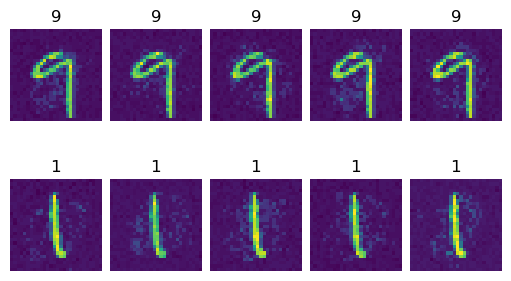

In [7]:
data, target = next(iter(loaders[0]))

temporal_data, _ = process_data(data, data_config)
temporal_data = torch.stack(
    temporal_data.split(temporal_data.shape[-1] // n_modules, -1), 1
)

fig, axs = plt.subplots(
    n_modules, temporal_data.shape[0], constrained_layout=True, figsize=(5, 3)
)
for t_data, t_axs in zip(temporal_data, axs.T):
    for d, ax, t in zip(t_data, t_axs, target[0].cpu().numpy()):
        ax.imshow(d[0].cpu().numpy().reshape(28, 28))
        ax.axis("off")
        ax.set_title(t)

## Init Models

Initialization of models with varying ammount of structural modularity

In [8]:
from dynspec.models import Community, init_model
from torch.nn import RNN, GRU, RNNCell, GRUCell
from dynspec.plotting import plot_model_masks
import pandas as pd
from dynspec.training import train_community, get_acc, get_loss
from dynspec.experiment import Experiment

In [9]:
# feel free to try other tasks, such as 'sum'
task = "parity-digits-both"

modules_config = {
    "n_modules": 2,
    "hidden_size": None,  # will be changed later
    "n_layers": 1,
    "dropout": 0.0,
    "cell_type": str(RNN),
}
connections_config = {"sparsity": None}  # Will be changed later
input_config = {"input_size": data_config["input_size"] ** 2, "common_input": False}
optim_config = {"lr": 1e-3, "weight_decay": 1e-5}
readout_config = {"common_readout": False}
decision = ["last", "max"]
training_config = {"n_epochs": 30, "task": task, "stop_acc": 0.95}

default_config = {
    "modules": modules_config,
    "connections": connections_config,
    "input": input_config,
    "readout": readout_config,
    "data": data_config,
    "decision": decision,
    "training": training_config,
    "optim": optim_config,
}

In [10]:
# We look at networks of 1/3 sizes and 5 sparsity levels
n_hiddens = [25]
# n_hiddens = [10, 25, 50][1:2]
# Negative values for the sparsity field directly specify number of connections (irrelevant of the hidden size) : eg -1 means exactly 1 connection
sparsities = [-1, 1e-2, 1e-1, 0.5, 1.0]
varying_params = {"hidden_size": n_hiddens, "sparsity": sparsities}

In [11]:
# Save yourself some training time by pre-loading the results, or check out training by yourself. On a gpu, it should take about 5 minutes per model (30 epochs)
experiment = Experiment(
    default_config, varying_params, load_save=True, n_tests=1, device=device
)

Results loaded


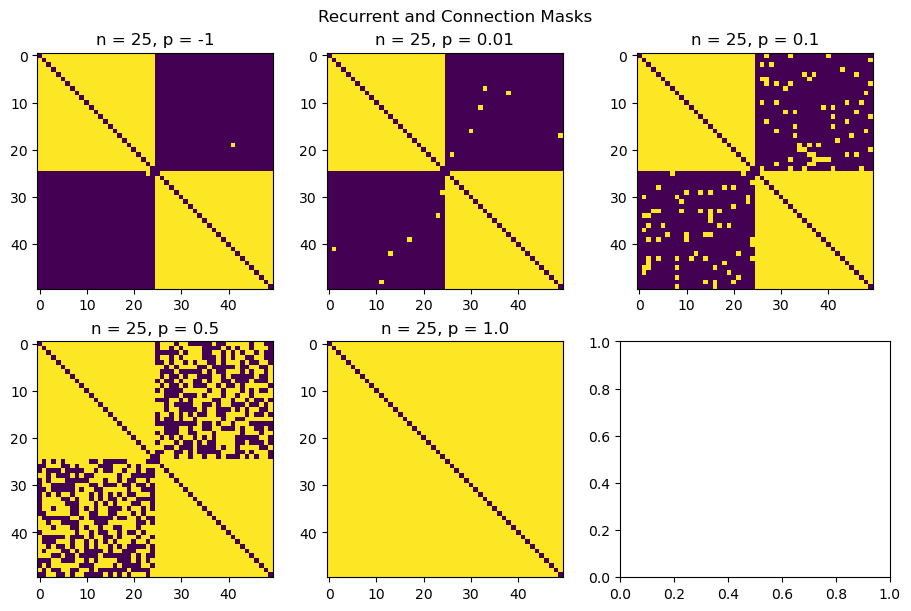

In [12]:
# plot the reccurent connections of the models, this changes depending on the sparsity of intereconnections
plot_model_masks(experiment, plot_input=False)

## Training

In [13]:
if not experiment.loaded:
    experiment.run(loaders, save=True)

### Results

In [14]:
from dynspec.plotting import plot_accs

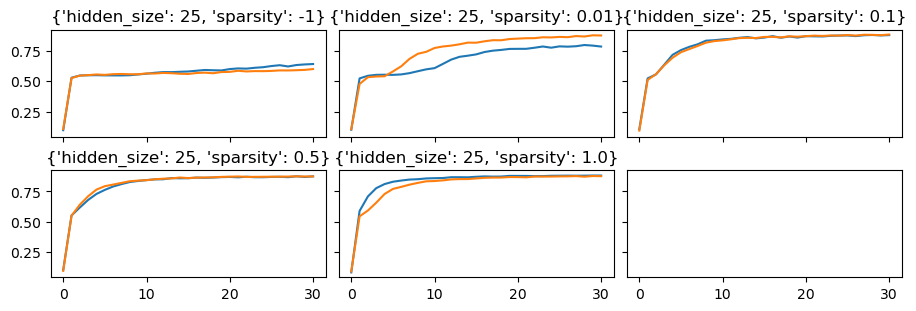

In [15]:
plot_accs(experiment.results)

## Metrics

In [16]:
from dynspec.plotting import set_style, filter_data
import pandas as pd
import seaborn as sns
from matplotlib.colors import LogNorm
from dynspec.metrics import global_diff_metric
from dynspec.plotting import plot_retraining_results

### Retraining

In [17]:
if (not experiment.loaded) or (not hasattr(experiment, "retrained_models")):
    experiment.compute_retraining_metric(loaders, save=True)

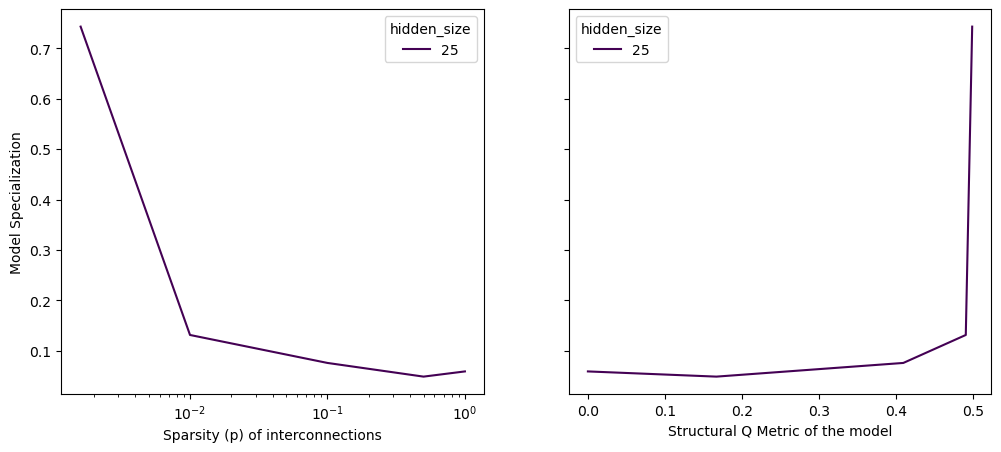

In [18]:
plot_retraining_results(experiment)

### Random Timings

In [19]:
from dynspec.plotting import plot_random_timings

In [20]:
if (not experiment.loaded) or (
    hasattr(experiment.results, "columns")
    and ("random_timing" not in experiment.results.columns)
):
    experiment.compute_random_timing(loaders, save=True)

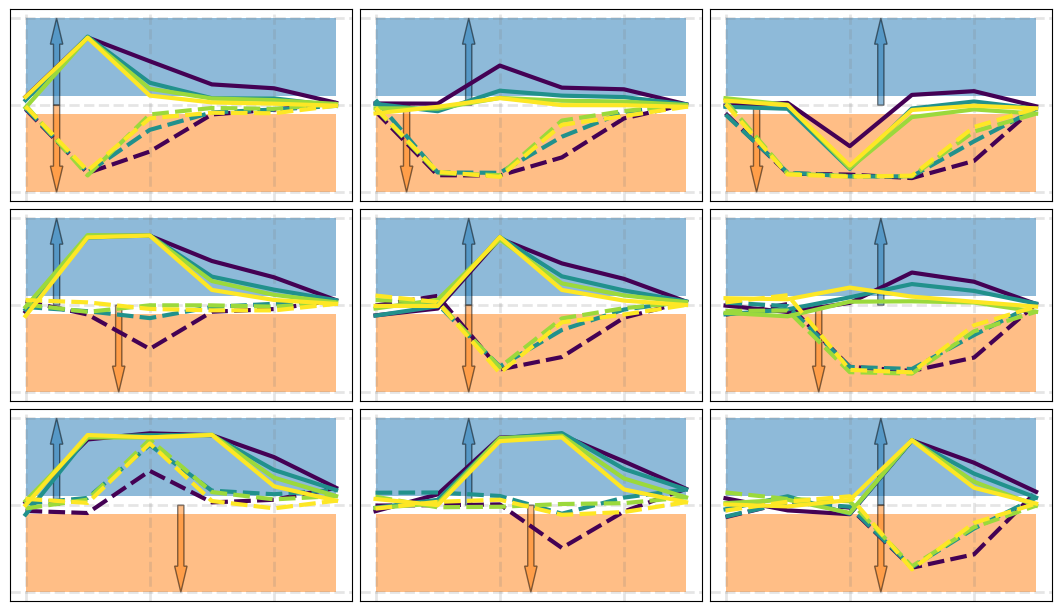

In [21]:
plot_random_timings(experiment)